In [ ]:
import os
import json

from sklearn import base
from sympy import per
experiment = f'simple_b64_aug_patience80'

performances = {}
for experiment in os.listdir('./experiments'):
    base_f1s = []
    target_f1s = []
    for run in os.listdir(f'./experiments/{experiment}'):
        metrics = json.load(open(f'./experiments/{experiment}/{run}/metrics.json'))
        base_model_on_target_val_f1 = metrics['best_target_val_f1_from_best_base_model']
        target_model_on_target_val_f1 = metrics['best_target_val_f1']

        base_f1s.append(base_model_on_target_val_f1)
        target_f1s.append(target_model_on_target_val_f1)
    performances[experiment] = (base_f1s, target_f1s)

# boxplot all performances
import pandas as pd
data = []
for experiment, (base_f1s, target_f1s) in performances.items():
    for base_f1, target_f1 in zip(base_f1s, target_f1s):
        data.append({'experiment': experiment, 'model': 'base', 'f1': base_f1})
        data.append({'experiment': experiment, 'model': 'target', 'f1': target_f1})
df = pd.DataFrame(data)

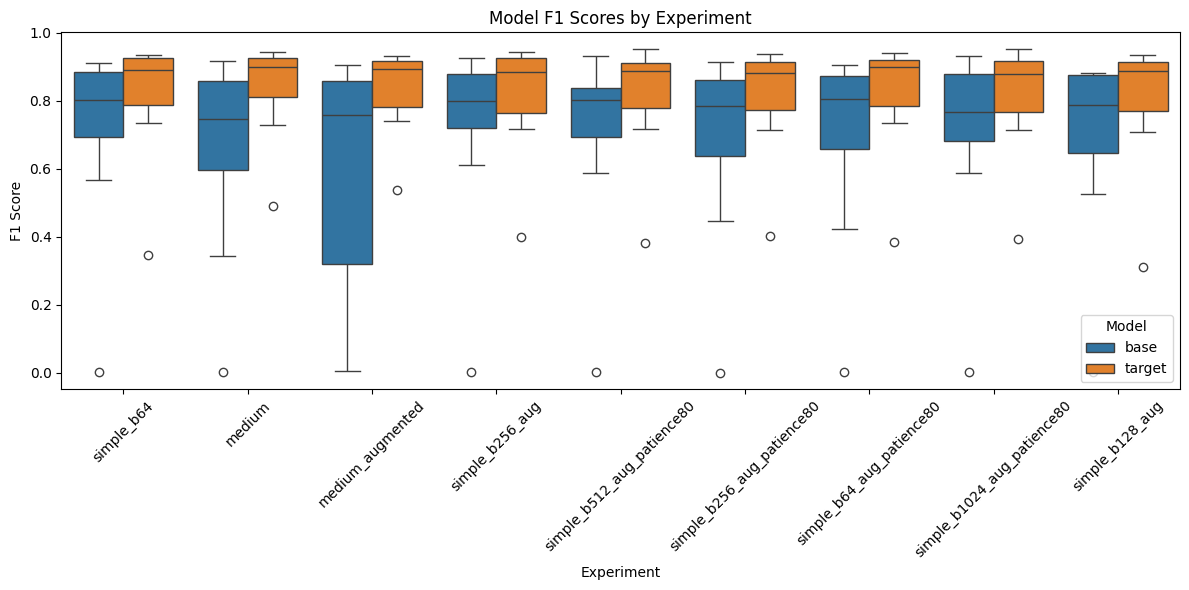

In [11]:
# boxplot df
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(x='experiment', y='f1', hue='model', data=df)
plt.title('Model F1 Scores by Experiment')
plt.ylabel('F1 Score')
plt.xlabel('Experiment')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
base_model_on_target_val_f1

0.0

In [9]:
import os
import json

data = []

for experiment in os.listdir('./experiments'):
    print(experiment)
    for run in os.listdir(f'./experiments/{experiment}'):
        metrics = json.load(open(f'./experiments/{experiment}/{run}/metrics.json'))
        base_model_on_target_val_f1 = metrics['best_target_val_f1_from_best_base_model']
        target_model_on_target_val_f1 = metrics['best_target_val_f1']

        data.append({'experiment': experiment, 'inverse relative f1': (target_model_on_target_val_f1 - base_model_on_target_val_f1) / (1 - base_model_on_target_val_f1 + 1e-5)})
        data.append({'experiment': experiment, 'absolute f1': (target_model_on_target_val_f1 - base_model_on_target_val_f1)})
        data.append({'experiment': experiment, 'target f1': (target_model_on_target_val_f1 )})
df = pd.DataFrame(data)

simple_b64
medium
medium_augmented
simple_b256_aug
simple_b512_aug_patience80
simple_b256_aug_patience80
simple_b64_aug_patience80
simple_b1024_aug_patience80
simple_b128_aug


In [13]:
df

,experiment,inverse relative f1,absolute f1,target f1
0,simple_b64,0.298537,NaN,NaN
1,simple_b64,NaN,0.031676,NaN
2,simple_b64,NaN,NaN,0.925581
3,simple_b64,0.486686,NaN,NaN
4,simple_b64,NaN,0.111646,NaN
...,...,...,...,...
211,simple_b128_aug,NaN,0.100278,NaN
212,simple_b128_aug,NaN,NaN,0.873524
213,simple_b128_aug,0.444407,NaN,NaN
214,simple_b128_aug,NaN,0.052632,NaN


In [16]:
# long to wide
df_wide = df.pivot_table(index=None, columns='experiment', values=['inverse relative f1', 'absolute f1', 'target f1'], aggfunc='median')
df_wide

experiment,medium,medium_augmented,simple_b1024_aug_patience80,simple_b128_aug,simple_b256_aug,simple_b256_aug_patience80,simple_b512_aug_patience80,simple_b64,simple_b64_aug_patience80
absolute f1,0.143434,0.104785,0.086396,0.101088,0.063238,0.066541,0.078631,0.067224,0.058878
inverse relative f1,0.455422,0.437662,0.315806,0.363289,0.271787,0.366703,0.356955,0.366645,0.390780
target f1,0.898746,0.894192,0.879746,0.887697,0.884877,0.882867,0.888291,0.891128,0.899953


/tmp/ipykernel_73933/551974421.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model')


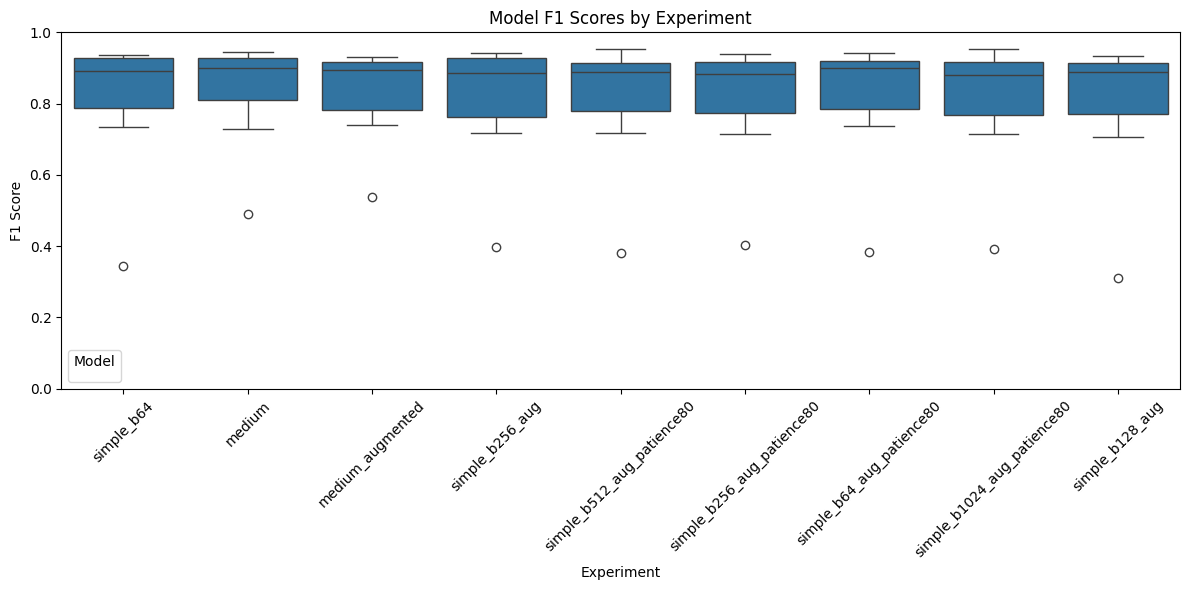

In [18]:
# boxplot df
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(x='experiment', y='target f1', data=df)
plt.title('Model F1 Scores by Experiment')
plt.ylabel('F1 Score')
plt.xlabel('Experiment')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim([0,1])
plt.show()

In [ ]:
import torch
import os
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from torch import nn
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import matplotlib.pyplot as plt
import math

from utils import SmokingCNN
model = SmokingCNN(window_size=3000, num_features=6)

base_model = SmokingCNN()
base_model.load_state_dict(torch.load(f'results/best_base_model.pt'))

custom_model = SmokingCNN()
custom_model.load_state_dict(torch.load(f'results/best_target_model.pt'))

batch_size = 512
fold = -1
    
data_path = f'data/001_test'
participants = ['alsaad','anam','asfik','ejaz','iftakhar','tonmoy','unk1','dennis']
target_participant = participants[fold]
participants.remove(target_participant)

base_train_dataset = ConcatDataset([TensorDataset(*torch.load(f'{data_path}/{p}_{s}.pt')) for p in participants for s in ['train', 'val']])
base_val_dataset = ConcatDataset([TensorDataset(*torch.load(f'{data_path}/{p}_test.pt')) for p in participants])

target_train_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_train.pt'))
target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))

base_valloader = DataLoader(base_val_dataset, batch_size=batch_size)
target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size)
target_valloader = DataLoader(target_val_dataset, batch_size=batch_size)
target_testloader = DataLoader(target_test_dataset, batch_size=batch_size)

In [ ]:
from utils import evaluate
evaluate(base_model, target_testloader, device='cuda')
evaluate(custom_model, target_testloader, device='cuda')

Target train dataset size: 9026
Target val dataset size: 3524
Target test dataset size: 1504
              precision    recall  f1-score   support

  No Smoking       0.74      0.88      0.80      1025
     Smoking       0.56      0.32      0.41       479

    accuracy                           0.70      1504
   macro avg       0.65      0.60      0.61      1504
weighted avg       0.68      0.70      0.68      1504



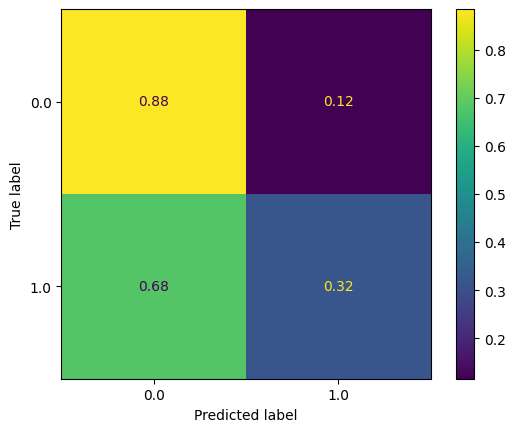

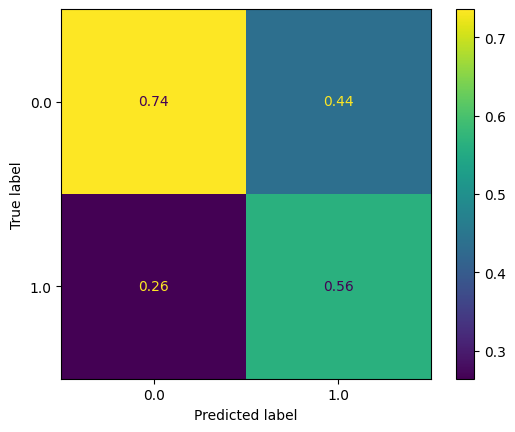

In [5]:
import os
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torch import nn
from utils_simple import compute_loss, optimize_model_and_compute_loss, plot_loss, evaluate
import torch
import matplotlib.pyplot as plt

# Hyperparameters
lr = 3e-3
batch_size = 32
early_stopping_patience = 50
window_size = 3000
data_path = f'data/001_test'
target_participant = 'dennis'

target_train_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_train.pt'))
target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))

print(f'Target train dataset size: {len(target_train_dataset)}')
print(f'Target val dataset size: {len(target_val_dataset)}')
print(f'Target test dataset size: {len(target_test_dataset)}')

# from utils import SmokingCNN
from utils import SimpleSmokingCNN
model = SimpleSmokingCNN(window_size=window_size, num_features=6)
model.load_state_dict(torch.load('experiments/exp_0012/best_model.pt'))
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
device = 'cuda'

trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(target_val_dataset, batch_size=batch_size)
testloader = DataLoader(target_test_dataset, batch_size=batch_size)

evaluate(model, testloader, device=device)